# A variational autoencoder in PyTorch

**[Faisal Z. Qureshi](http://vclab.science.uoit.ca)**  

Check out excellent PyTorch tutorials by "SherlockLiao" at [https://github.com/L1aoXingyu/pytorch-beginner](https://github.com/L1aoXingyu/pytorch-beginner)

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## CUDA Support

In [2]:
for i in range(torch.cuda.device_count()):
    print("Found device:", torch.cuda.get_device_name(i))

if torch.cuda.device_count() == 0:
    print("No GPU device found")
else:
    print("Current cuda device is", torch.cuda.get_device_name(torch.cuda.current_device()))

Found device: GeForce GTX TITAN X
Found device: GeForce GTX 980
Current cuda device is GeForce GTX TITAN X


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## MNIST Dataset

In [4]:
batch_size = 128

my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('../datasets', transform=my_transforms, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [5]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## A Variational Autoencoder

### `reparametrize(self, mu, logvar)`

`logvar` = $\log \sigma^2$    
`mu` = $\mu$

$$
\begin{eqnarray}
\sigma & = & \exp \left( \frac{1}{2} \log \sigma^2 \right) \\
& = & \exp \left( \log \sigma^{2 ^ \frac{1}{2}} \right) \\
& = & \exp \log \sigma \\
& = & \sigma
\end{eqnarray}
$$

How to generate a random from normal distribution with mean $\mu$ and variance $\sigma^2$?

1. Generate $x \sim \mathcal{N}(0,1)$.
2. Compute $y = \sigma x + \mu$.  Here $y \sim \mathcal{N}(\mu,\sigma^2)$  


In [6]:
class var_autoencoder(nn.Module):
    def __init__(self):
        super(var_autoencoder, self).__init__()

        self.fc1 = nn.Linear(784, 400)       # These layers will be used for encoding 
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)        # These layers will be used for decoding
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x: Variable) -> (Variable, Variable):
        h1 = F.relu(self.fc1(x))             # h1 is 400-dimensional vector
        return self.fc21(h1), self.fc22(h1)  # this returns two 20-dimensional vectors

    def reparametrize(self, mu: Variable, logvar: Variable) -> Variable:
        if self.training:
            std = logvar.mul(0.5).exp_()
            if torch.cuda.is_available():
                eps = torch.cuda.FloatTensor(std.size()).normal_()
            else:
                eps = torch.FloatTensor(std.size()).normal_()
            eps = Variable(eps)
            return eps.mul(std).add_(mu)         # Latent variable z is 20-dimensional 
        else:
            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = F.relu(self.fc3(z))             # z can be used to generate new samples
        return torch.sigmoid(self.fc4(h3))       # remember that z ~ N(mu, var)

    def forward(self, x: Variable) -> (Variable, Variable, Variable):                    
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

## Training

In [7]:
model = var_autoencoder().to(device)

learning_rate = 1e-2
weight_decay = 1e-5
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=learning_rate, 
                             weight_decay=weight_decay)

## Kullback-Leibler Divergence

A measure of how one probability distribution is different from a second, reference probability distribution.  It is also called *relative entropy.*  A KL Divergence of 0 means that the two distributions are identical.

$$
D_{KL}(P || Q) = - \sum_{x \in \mathcal{X}} P(x) \log \frac{Q(x)}{P(x)}
$$

### KL Divergence of $P(x)$ and $\mathcal{N}(0,1)$

TO DO

In [8]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    #print(recon_x.shape)
    #print(x.view(-1,784).shape)
    #print(torch.max(recon_x))
    #print(torch.max(x))
    #print(torch.min(recon_x))
    #print(torch.min(x))
    
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))
    
    # KLD is Kullback–Leibler divergence -- how much does one learned
    # distribution deviate from another, in this specific case the
    # learned distribution from the unit Gaussian

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    #
    # - D_{KL} = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # note the negative D_{KL} in appendix B of the paper
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KLD /= batch_size * 784
    
    return BCE + KLD

In [10]:
start_epoch = 4
num_epochs = 8

for epoch in range(start_epoch, start_epoch+num_epochs):
    for data in dataloader:
        optimizer.zero_grad()
        
        image, _ = data
        image = image.to(device)
        
        recon, mu, logvar = model(image)        
        loss = loss_function(recon, image, mu, logvar)
        
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch, 
                  start_epoch+num_epochs-1, 
                  loss.data.item()))

pic = to_img(recon.cpu().data)
save_image(pic, 'images/image-conv_{}.png'.format(epoch))

epoch [4/11], loss:-39.4244
epoch [5/11], loss:-36.7018
epoch [6/11], loss:-37.1677
epoch [7/11], loss:-35.7224
epoch [8/11], loss:-35.9028
epoch [9/11], loss:-39.4145
epoch [10/11], loss:-36.1330
epoch [11/11], loss:-37.3856


A simple check

torch.Size([128, 1, 28, 28])


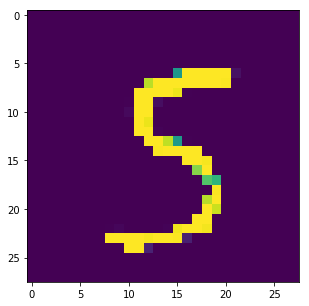

In [11]:
for data in dataloader:
    img, _ = data
    img = img.to(device)
    
    output, _, _ = model(img)
    
    pic = to_img(output.cpu().data)
    print(pic.shape)
    break
    
plt.figure(figsize=(5,5))
plt.imshow(pic[0,0,:,:])

### Data Preprocessing

Ensure that you do not normalize data.  Since we get the image from dataset itself, the images are already normalized.

torch.Size([1, 28, 28]) tensor(3)


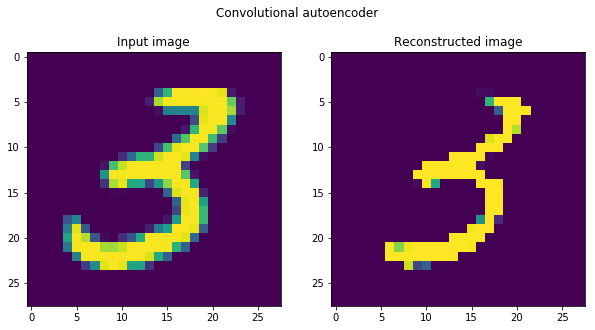

In [12]:
image, label = dataset[867]
print(image.shape, label)

input_img = image
output_img, _, _ = model(input_img.unsqueeze(0).to(device))

plt.figure(figsize=(10,5))
plt.suptitle('Convolutional autoencoder')
plt.subplot(121)
plt.title('Input image')
plt.imshow(image[0])
plt.subplot(122)
plt.title('Reconstructed image')
plt.imshow(output_img[0,:].view(28,28).cpu().detach())

## Saving the trained model

Now that training is done, it is a good idea to save the trained model.

We will save enough information that would allow us to:

1. Use the trained model; and
2. Retrain the trained model from the place where we left off.

In [13]:
def save_checkpoint(model, optimizer, epoch, filename):
    state = {
        'epoch': epoch,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    try:
        torch.save(state, filename)
        print('Saved checkpoint "{}" (epoch {})'.format(filename, epoch))
    except:
        print('Failed to save checkpoint "{}"'.format(filename))

def load_checkpoint(filename, model, optimizer=None):
    """
    Loads model and optimizer from a file.
    
    If optimizer is None, only loads model.
    """
    import os
    start_epoch = 0
    if os.path.isfile(filename):
        print('Loading checkpoint "{}"'.format(filename))
        try:
            checkpoint = torch.load(filename)
            model.load_state_dict(checkpoint['model'])
            if optimizer:
                start_epoch = checkpoint['epoch']+1
                optimizer.load_state_dict(checkpoint['optimizer'])
            print('Loaded checkpoint "{}" (epoch {})'.format(filename, start_epoch))
        except:
            print('Cannot load checkpoint "{}"'.format(filename))
    else:
        print('Cannot find checkpoint "{}"'.format(filename))
    return model, optimizer, start_epoch

In [14]:
filename = 'conv-vae.pt'
save_checkpoint(model, optimizer, epoch, filename)

Saved checkpoint "conv-vae.pt" (epoch 11)


## Loading the trained model

Recall that we do not store the structure of the model.  We simply store the weights.  So we will first create the model and then load in the weights.

Since we do not wish to resume training, we  will not load the optimizer.

In [16]:
filename = 'conv-vae.pt'

model2 = var_autoencoder().to(device)
model2, _, _ = load_checkpoint(filename, model2)

Loading checkpoint "conv-vae.pt"
Loaded checkpoint "conv-vae.pt" (epoch 0)


## Inference

Now lets pass an image through the learned model and see what we get

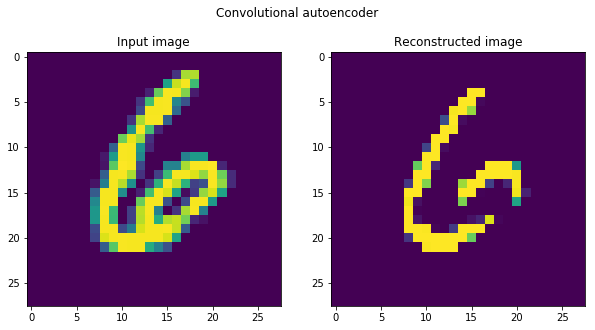

In [20]:
image, label = dataset[13]

input_img = image
output_img, _, _ = model2(input_img.unsqueeze(0).to(device))

plt.figure(figsize=(10,5))
plt.suptitle('Convolutional autoencoder')
plt.subplot(121)
plt.title('Input image')
plt.imshow(image[0])
plt.subplot(122)
plt.title('Reconstructed image')
plt.imshow(output_img[0,:].view(28,28).cpu().detach())